# Prepare notebook

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pyLDAvis
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import string
from wordcloud import WordCloud
from plotting_utilities import *

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/acraig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/acraig/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import data

In [3]:
books = pd.read_pickle('2019112_goodreads_book_data.pkl')

In [4]:
len(books)

610

In [5]:
books.goodreads_author_bio.count()

439

# Prepare textual data

In [6]:
alphanumeric_filter = re.compile('[\W_]+')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

books['filtered_author_bio'] = books.goodreads_author_bio.fillna('')\
                                    .map(lambda x: alphanumeric_filter.sub(' ', x).lower().strip())\
                                    .map(lambda text: ' '.join([wnl.lemmatize(token) for token in wpt.tokenize(text) 
                                                                 if token not in stop_words
                                                               ]))


<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<ipython-input-6-0d2d354b2431>:1: DeprecationWarning: invalid escape sequence \W
  alphanumeric_filter = re.compile('[\W_]+')


In [7]:
books['filtered_doc_length'] = books.filtered_author_bio.map(lambda text: len(text.split(' ')))

 # Visualization

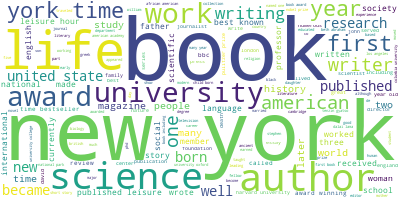

In [8]:
# Generate a word cloud based on all author_bios
wordcloud = WordCloud(background_color="white", max_words=1000)
wordcloud.generate(','.join(list(books.filtered_author_bio.values)))
wordcloud.to_image()

# Word counting methods

In [10]:
max_df=0.90
min_df=4
max_features=2000


### Bag of words

In [53]:
# Fit and transform the author_bios
word_bag_cv = CountVectorizer(ngram_range=(1,1), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
word_bag_counts = word_bag_cv.fit_transform(books.filtered_author_bio.drop_duplicates())

# Check against visualization
n = 5
counts = word_bag_counts.toarray().sum(axis = 0)
words = word_bag_cv.get_feature_names()
[words[i] for i in np.argpartition(counts, -n)[-n:]] 

['author', 'time', 'new', 'book', 'university']

### Bag of bigrams

In [54]:
# Fit and transform the author_bios
bigram_bag_cv = CountVectorizer(ngram_range=(2,2), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
bigram_bag_counts = bigram_bag_cv .fit_transform(books.filtered_author_bio.drop_duplicates())

# Check against visualization
n = 5
counts = bigram_bag_counts.toarray().sum(axis = 0)
bigrams = bigram_bag_cv.get_feature_names()
[bigrams[i] for i in np.argpartition(counts, -n)[-n:]] 

['award winning', 'best known', 'united state', 'new york', 'york time']

### Bag of trigrams

In [55]:
# Fit and transform the author_bios
trigram_bag_cv = CountVectorizer(ngram_range=(3,3), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
trigram_bag_counts = trigram_bag_cv.fit_transform(books.filtered_author_bio.drop_duplicates())

# Check against visualization
n = 5
counts = trigram_bag_counts.toarray().sum(axis = 0)
trigrams = trigram_bag_cv.get_feature_names()
[trigrams[i] for i in np.argpartition(counts, -n)[-n:]] 

['author new york',
 'los angeles time',
 'york time bestseller',
 'new york time',
 'new york city']

### TF-IDF 

In [56]:
tfidf_v = TfidfVectorizer(use_idf=True, max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english' )
tfidf_weights = tfidf_v.fit_transform(books.filtered_author_bio.drop_duplicates())

# Check against visualization
n = 10
weights = tfidf_weights.toarray().sum(axis = 0)
weighted_words = tfidf_v.get_feature_names()
[weighted_words[i] for i in np.argpartition(weights, -n)[-n:]] 

['american',
 'science',
 'life',
 'university',
 'time',
 'york',
 'professor',
 'author',
 'new',
 'book']

# Topic Modeling

In [57]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [58]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_components = 20

def print_top_words(model, feature_names, n_top_words = 10):
    for topic_idx, topic in enumerate(model.components_):
        message = " Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [59]:
# Fit the NMF model (Frobenius norm)
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (Frobenius norm):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (Frobenius norm):
 Topic #0: new york time book bestseller magazine author best washington writer
 Topic #1: university professor biology harvard ecology director american oxford department study
 Topic #2: born book novel year american published life story author english
 Topic #3: database goodreads librarian note information author yale john institute foundation
 Topic #4: award prize book finalist national winning winner 2015 macarthur body
 Topic #5: college cambridge fellow oxford school london british educated university andrew
 Topic #6: history historian specialist military god war anthropology modern book emeritus
 Topic #7: television queer series personality netflix eye expert emmy reality host
 Topic #8: science scientist magazine academy society national writer winning dr washington
 Topic #9: greek play ancient athens bc written roman edition playwright classical
 Topic #10: chicago president state united law african south university school michelle


In [60]:
# Fit the NMF model (generalized Kullback-Leibler divergence)
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (generalized Kullback-Leibler divergence):
 Topic #0: new time book york published national public writing university award
 Topic #1: professor university department research biology center director science psychology fellow
 Topic #2: born known english novel lady father lived published year novelist
 Topic #3: author goodreads note database librarian college university new study school
 Topic #4: award american national author prize winning academy including book essay
 Topic #5: history book scientific london science magazine life international royal article
 Topic #6: author best history known century language american professor time effect
 Topic #7: book english british television author film actor series comedian academic
 Topic #8: time born author new work writer journalism york magazine appeared
 Topic #9: ancient literature greek bc athens near academy great roman good
 Topic #10: state united child president year chair helped family chicago working
 To

In [61]:
# Fit LDA model 
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(word_bag_counts)
print("\nTopics in LDA model:")
print_top_words(lda, word_bag_cv.get_feature_names())


Topics in LDA model:
 Topic #0: life center fellow university thing work author www time selling
 Topic #1: royal hospital surgeon major author book psychology london american documentary
 Topic #2: librarian goodreads database note biological elizabeth francisco author australian san
 Topic #3: memory prize nobel understand wanted university science founding eric paul
 Topic #4: travel university history journal lived extensive chicago influence text working
 Topic #5: essay home 1988 animal note year time acclaimed author published
 Topic #6: university book born new author year science work professor life
 Topic #7: jonathan album award emmy series know science queer star eye
 Topic #8: stephen time oxford wife good college author mathematics johnson artist
 Topic #9: history book professor university fellow science language work oxford royal
 Topic #10: american crime president university chicago state robert james religion united
 Topic #11: medicine research new washington depar

In [65]:


lda_data =  pyLDAvis.prepare(topic_term_dists = lda.components_, 
                             doc_topic_dists = lda.transform(word_bag_counts.toarray()), 
                             doc_lengths = books.drop_duplicates(subset = ['filtered_author_bio']).filtered_doc_length.values,
                             vocab = word_bag_cv.get_feature_names(),
                             term_frequency = word_bag_counts.toarray().sum(axis = 0),
                             sort_topics=True)
pyLDAvis.display(lda_data)

/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [66]:
from sklearn.metrics import log_loss, make_scorer, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

In [67]:
def custom_scorer_highest_topic_silhouette(estimator, X):
    X = X.toarray()
    return silhouette_score(X, np.argmax(estimator.transform(X), axis =1))
  
def custom_scorer_highest_topic_calinski_harabasz(estimator, X):
    X = X.toarray()
    return calinski_harabasz_score(X, np.argmax(estimator.transform(X), axis =1))


def custom_scorer_kmeans_silhouette(estimator, X):
    X = X.toarray()
    kmeans_model = KMeans(n_clusters=estimator.n_components, random_state=1).fit(X)
    labels = kmeans_model.labels_
    return silhouette_score(X, labels)
  
def custom_scorer_kmeans_calinski_harabasz(estimator, X):
    X = X.toarray()
    kmeans_model = KMeans(n_clusters=estimator.n_components, random_state=1).fit(X)
    labels = kmeans_model.labels_
    return calinski_harabasz_score(X, labels)

def custom_scorer_log_likelihood(estimator, X):
    X = X.toarray()
    return estimator.score(X)

def custom_scorer_negative_perplexity(estimator, X):
    X = X.toarray()
    return -1*estimator.perplexity(X)

In [68]:
scoring = {'silhoutte_simple_cluster':custom_scorer_highest_topic_silhouette, 
           'silhoutte_kmeans_cluster': custom_scorer_kmeans_silhouette,
           'calinski_harabasz_simple_cluster':custom_scorer_highest_topic_calinski_harabasz, 
           'calinski_harabasz_kmeans_cluster': custom_scorer_kmeans_calinski_harabasz,
           'log_likelihood': custom_scorer_log_likelihood,
           'negative_perplexity': custom_scorer_negative_perplexity}

param_grid={'n_components': [2, 4, 6], 
                                    'learning_decay': [.5, .7, .9],
                                    'learning_offset': [20, 30, 40], 
                                    'max_iter': [50, 75, 100]}

# By default, scoring will be the LDA "score" method, which is log-likelihood
model_lda = GridSearchCV(LatentDirichletAllocation(),
                        param_grid=param_grid,
                         scoring = scoring, refit = 'log_likelihood',
                        cv=3, n_jobs = -1, verbose = 2)
model_lda.fit(word_bag_counts)
results = model_lda.cv_results_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  4.6min finished


In [69]:
import pickle
pickle.dump(model_lda, open('gridsearchcv_lda_customScoring_author_bios.pkl', 'wb'))

In [71]:
lda_data =  pyLDAvis.prepare(topic_term_dists = model_lda.best_estimator_.components_, 
                             doc_topic_dists = model_lda.best_estimator_.transform(word_bag_counts.toarray()), 
                             doc_lengths = books.drop_duplicates(subset = ['filtered_author_bio']).filtered_doc_length.values,
                             vocab = word_bag_cv.get_feature_names(),
                             term_frequency = word_bag_counts.toarray().sum(axis = 0),
                             sort_topics=True)
pyLDAvis.display(lda_data)

/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [72]:
print("\nTopics in LDA model:")
print_top_words(model_lda.best_estimator_, word_bag_cv.get_feature_names())


Topics in LDA model:
 Topic #0: university professor book born year work school author history science
 Topic #1: new book time york award author american life science best



In [73]:
results = None

for score in scoring.keys():
    if results is None:
        results = pd.DataFrame(model_lda.cv_results_['mean_test_'+score], columns = ['mean_test_'+score])\
                     .join(pd.DataFrame(model_lda.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
    else:
        results = results.join(pd.DataFrame(model_lda.cv_results_['mean_test_'+score], columns = ['mean_test_'+score]))\
                     .join(pd.DataFrame(model_lda.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
for param in param_grid.keys():
    results = results.join(pd.DataFrame(model_lda.cv_results_['param_'+param].data, columns = [param]))
results

,mean_test_silhoutte_simple_cluster,std_test_silhoutte_simple_cluster,mean_test_silhoutte_kmeans_cluster,std_test_silhoutte_kmeans_cluster,mean_test_calinski_harabasz_simple_cluster,std_test_calinski_harabasz_simple_cluster,mean_test_calinski_harabasz_kmeans_cluster,std_test_calinski_harabasz_kmeans_cluster,mean_test_log_likelihood,std_test_log_likelihood,mean_test_negative_perplexity,std_test_negative_perplexity,n_components,learning_decay,learning_offset,max_iter
0,-0.001979,0.009543,0.424766,0.109052,2.313701,0.260019,8.879935,1.202538,-47560.670566,2716.573350,-1229.919898,88.953737,2,0.5,20,50
1,-0.131264,0.059437,0.294452,0.093974,1.315260,0.276891,6.758659,1.599656,-49938.768131,2872.193632,-1754.208416,120.319757,4,0.5,20,50
2,-0.202805,0.085360,0.273016,0.096414,1.210781,0.197496,6.018963,0.744417,-51815.739915,2731.432556,-2336.430070,249.245906,6,0.5,20,50
3,0.003069,0.006687,0.424766,0.109052,2.368358,0.261477,8.879935,1.202538,-47546.721072,2735.978773,-1226.866128,85.558420,2,0.5,20,75
4,-0.085023,0.006317,0.294452,0.093974,1.753243,0.213036,6.758659,1.599656,-49837.267110,2936.997340,-1725.805407,107.129213,4,0.5,20,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,-0.091692,0.024154,0.294452,0.093974,1.706119,0.064933,6.758659,1.599656,-49724.067727,2780.059567,-1700.913903,128.036030,4,0.9,40,75
77,-0.135659,0.025474,0.273016,0.096414,1.297891,0.112768,6.018963,0.744417,-51874.016726,2676.293264,-2356.902221,245.574795,6,0.9,40,75
78,0.000399,0.008000,0.424766,0.109052,2.028668,0.044960,8.879935,1.202538,-47584.550393,2780.687308,-1233.733819,90.192537,2,0.9,40,100
79,-0.102779,0.038248,0.294452,0.093974,1.300250,0.103854,6.758659,1.599656,-50021.205418,2896.178722,-1778.708680,153.595776,4,0.9,40,100


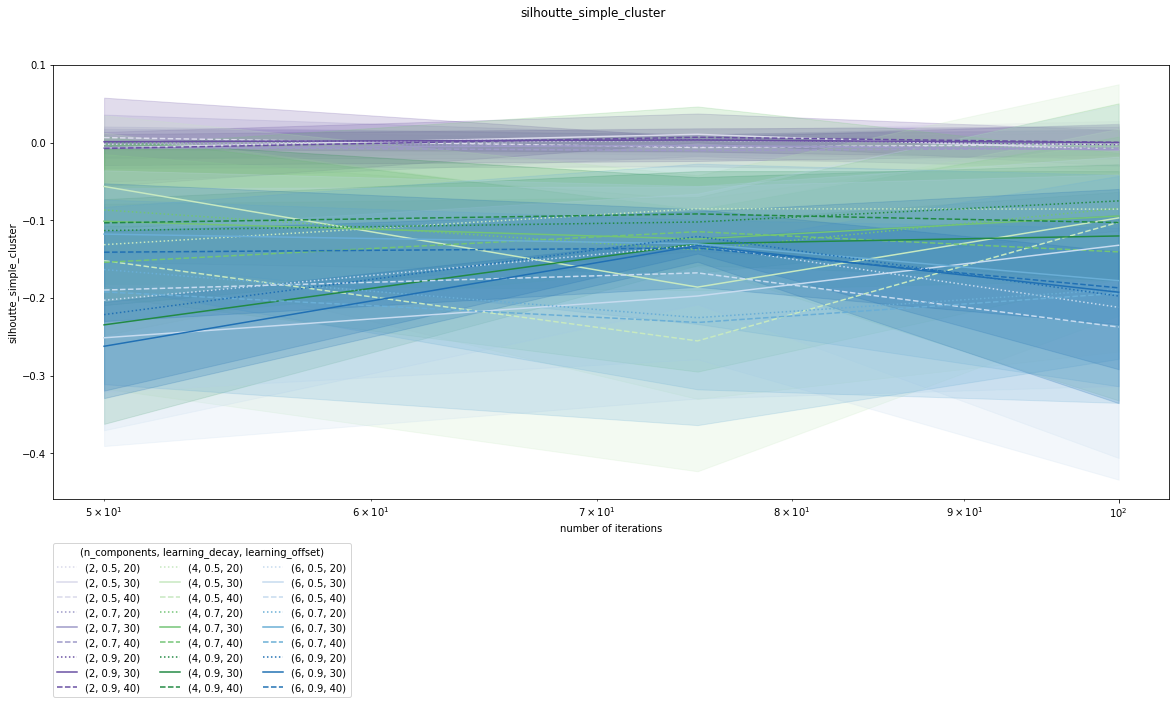

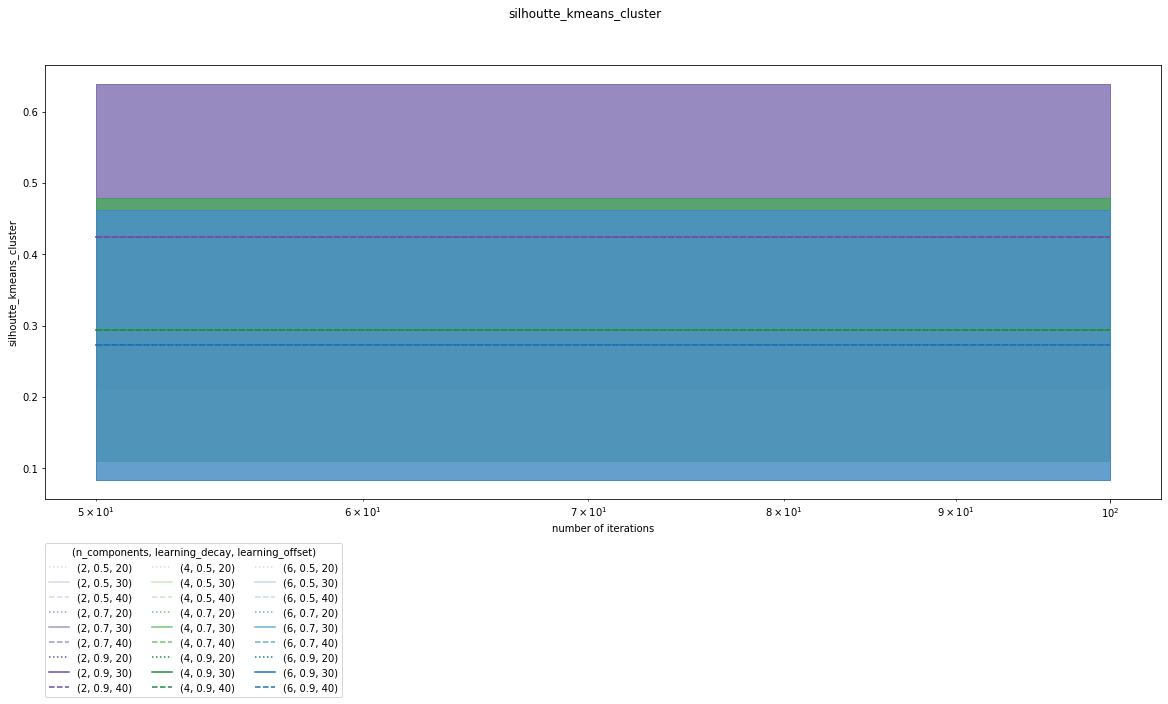

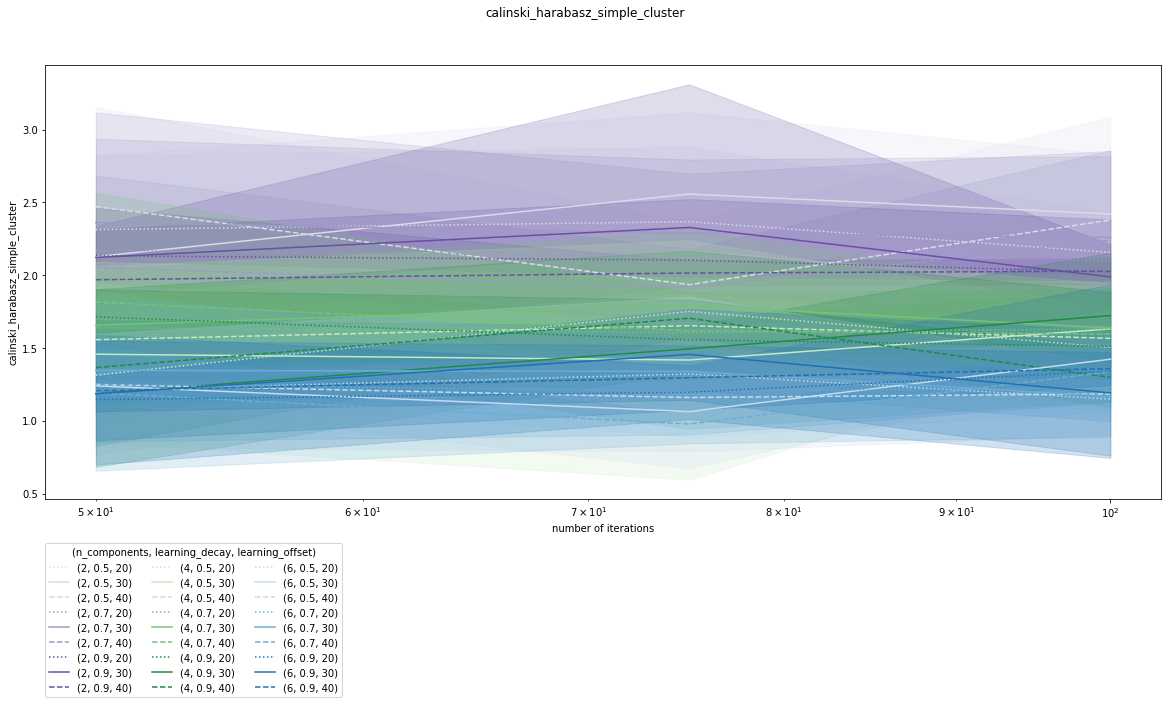

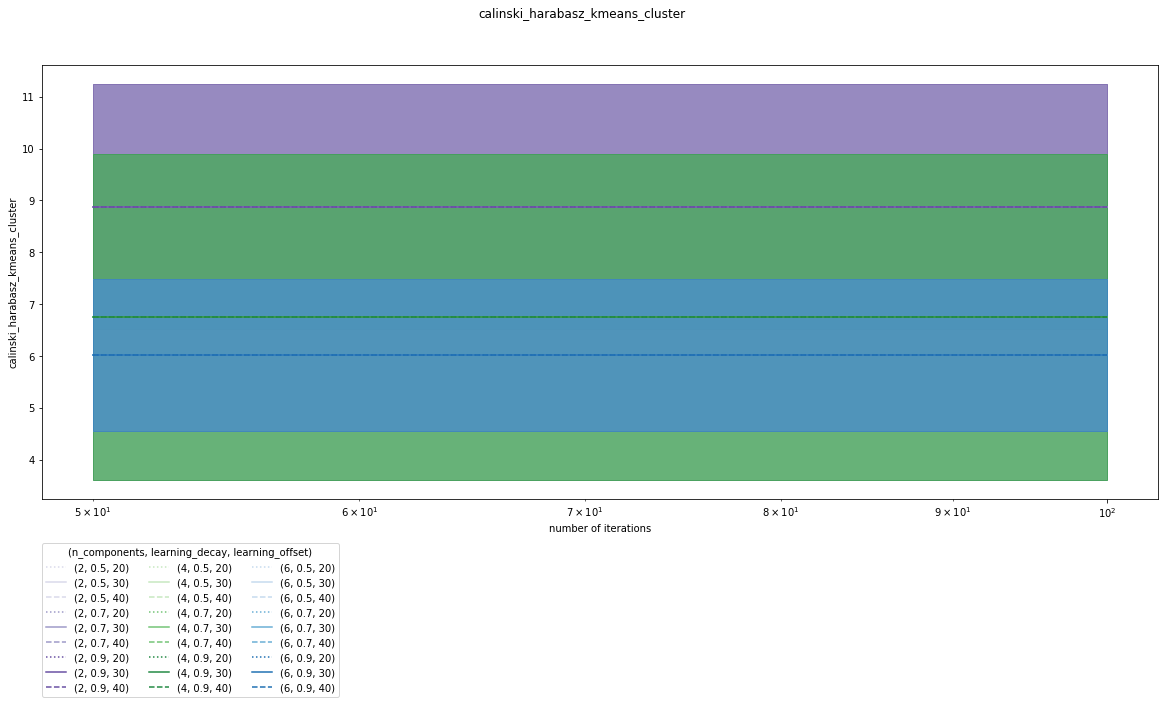

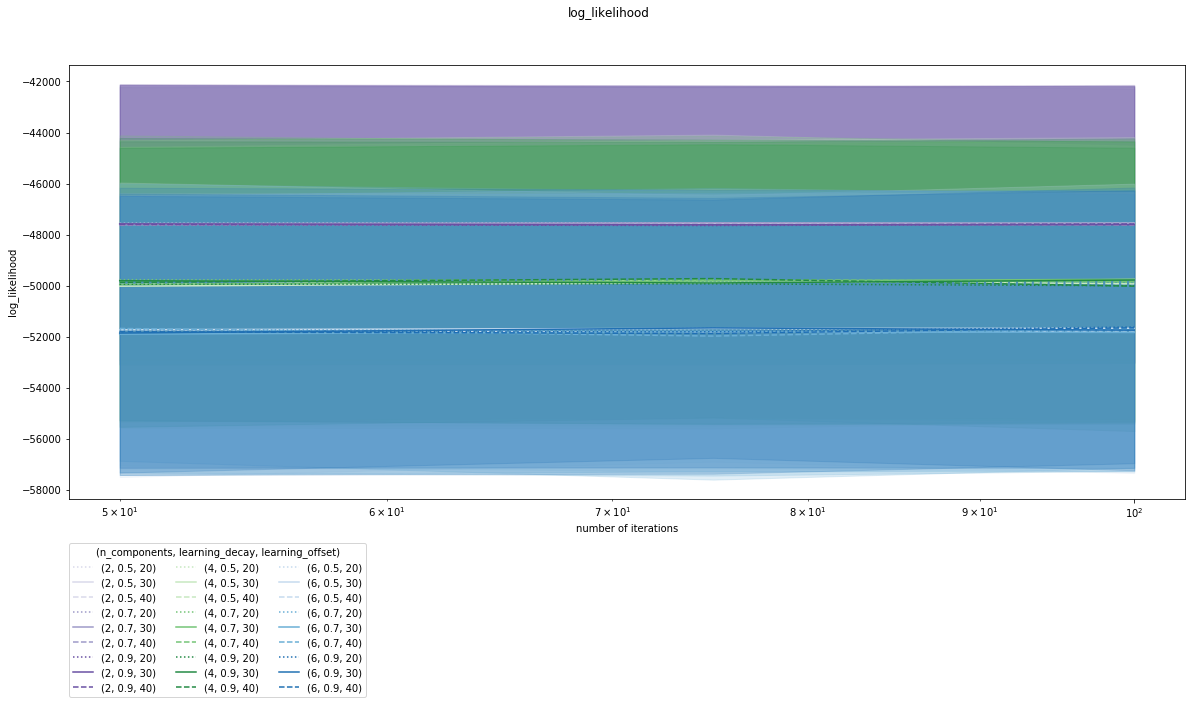

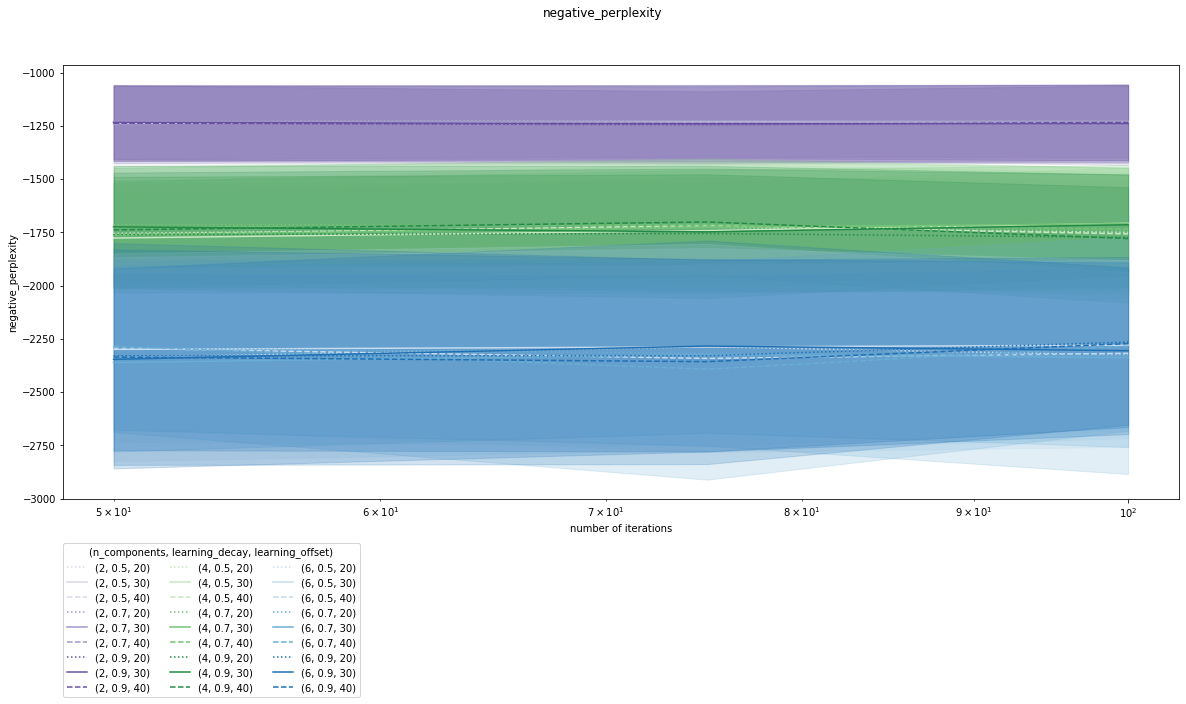

In [74]:
for score in scoring.keys():
    fig, ax = plt.subplots(1,1, figsize = (20,8))
    fig.suptitle(score)
    
    color_group_map = {2: 'Purples', 4: 'Greens', 6: 'Blues'}
    learning_decay_map = {0.5: 0.25, 0.7: 0.5, 0.9:0.75}
    learning_offset_map = {20:':', 30:'-', 40:'--'}

    for n_components, color_group in results.groupby('n_components'):
        cmap = matplotlib.cm.get_cmap(color_group_map[n_components])
        for learning_decay, intensity_group in color_group.groupby('learning_decay'):
            color = cmap(learning_decay_map[learning_decay])
            for learning_offset, linestyle_group in intensity_group.groupby('learning_offset'):
                linestyle = learning_offset_map[learning_offset]
                linestyle_group = linestyle_group.sort_values('max_iter')

                ax.plot(linestyle_group['max_iter'], linestyle_group['mean_test_'+score], 
                                          color = color, linestyle = linestyle, 
                                          label = '(%d, %.1f, %d)'%(n_components, learning_decay, learning_offset))
                ax.fill_between(x = linestyle_group['max_iter'].astype(float), 
                               y1 = linestyle_group['mean_test_'+score] - 1.96*linestyle_group['std_test_'+score],
                               y2 = linestyle_group['mean_test_'+score] + 1.96*linestyle_group['std_test_'+score],
                               color = color, alpha = 0.2)
    ax.legend(title = '(n_components, learning_decay, learning_offset)', 
              ncol = 3, bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.)

    ax.set_xscale('log')
    ax.set_xlabel('number of iterations')
    ax.set_ylabel(score)

In [76]:
scoring = {'silhoutte_simple_cluster':custom_scorer_highest_topic_silhouette, 
           'silhoutte_kmeans_cluster': custom_scorer_kmeans_silhouette,
           'calinski_harabasz_simple_cluster':custom_scorer_highest_topic_calinski_harabasz, 
           'calinski_harabasz_kmeans_cluster': custom_scorer_kmeans_calinski_harabasz,
           #'log_likelihood': custom_scorer_log_likelihood,
           #'negative_perplexity': custom_scorer_negative_perplexity
          }

param_grid={'n_components': [2,4,6], 
                                    'alpha': [0.5, .1, .2, .4],
                                    'l1_ratio': [0.25,0.5,0.75], 
                                    'max_iter': [50, 75, 100]}

# By default, scoring will be the LDA "score" method, which is log-likelihood
model_nmf = GridSearchCV(NMF(beta_loss='kullback-leibler', solver='mu'),
                        param_grid=param_grid,
                         scoring = scoring, refit = 'silhoutte_kmeans_cluster',
                        cv=3, n_jobs = -1, verbose = 2)
model_nmf.fit(tfidf_weights)
results = model_nmf.cv_results_

pickle.dump(model_lda, open('gridsearchcv_nmf_customScoring_athor_bios.pkl', 'wb'))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   26.7s finished


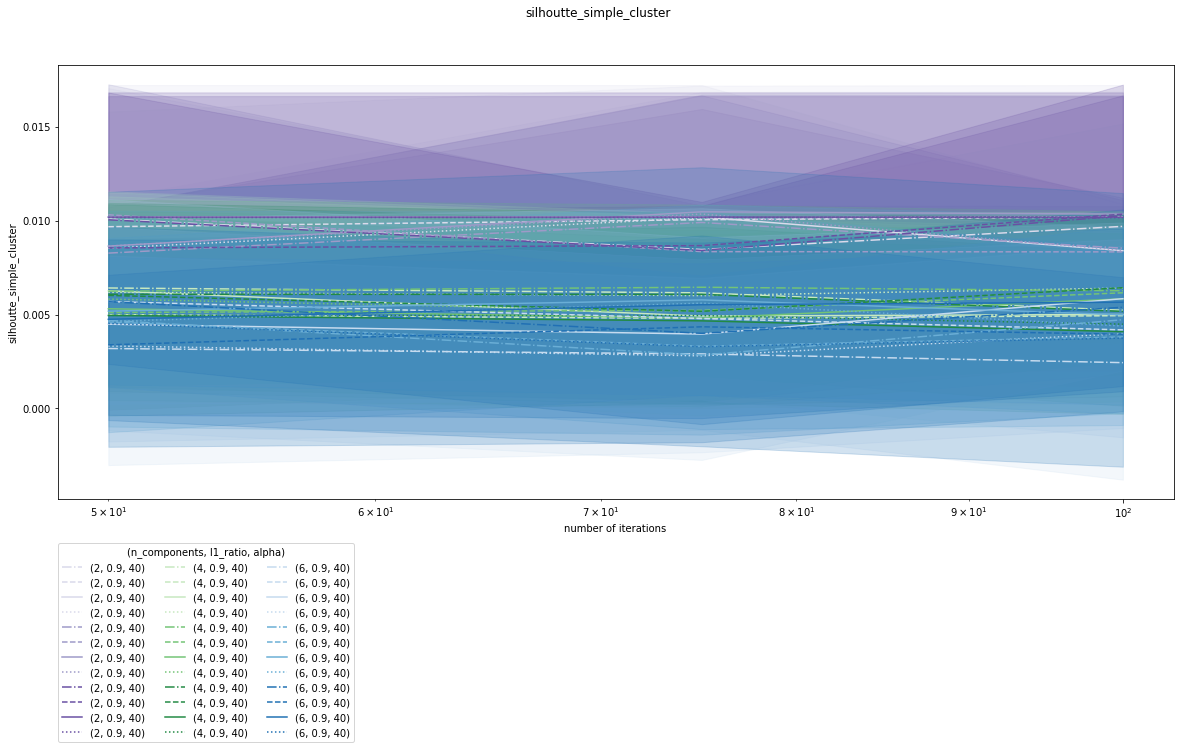

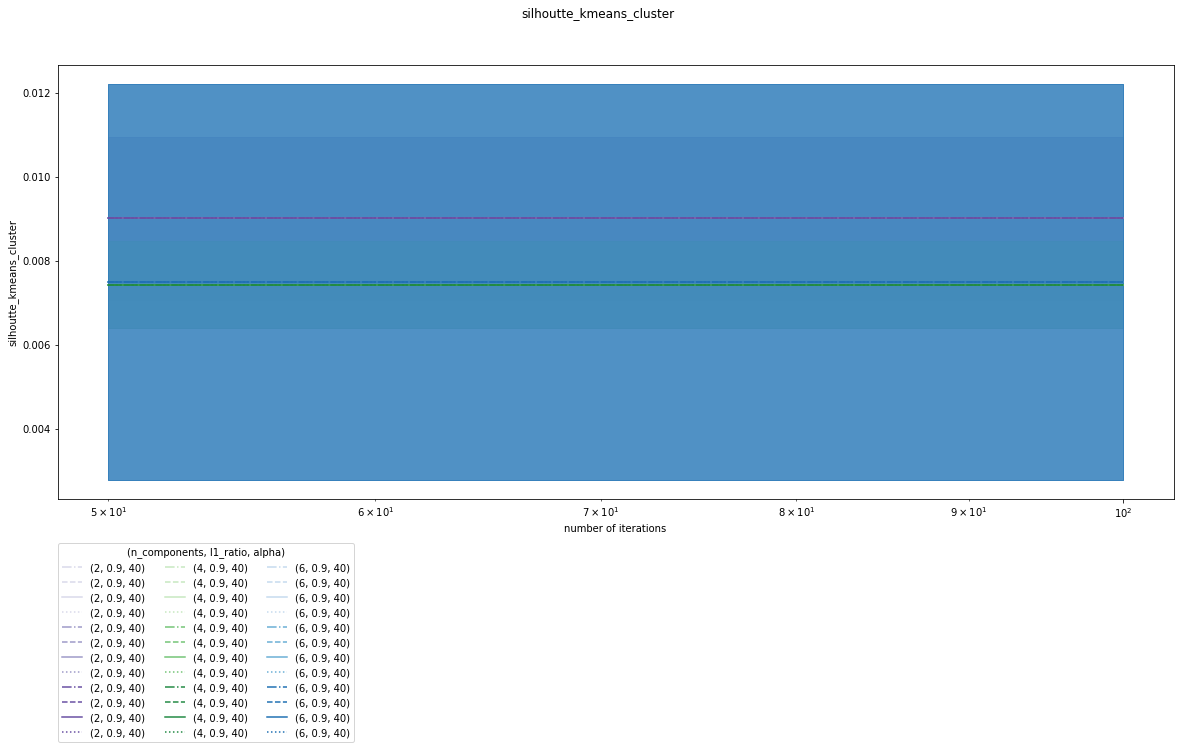

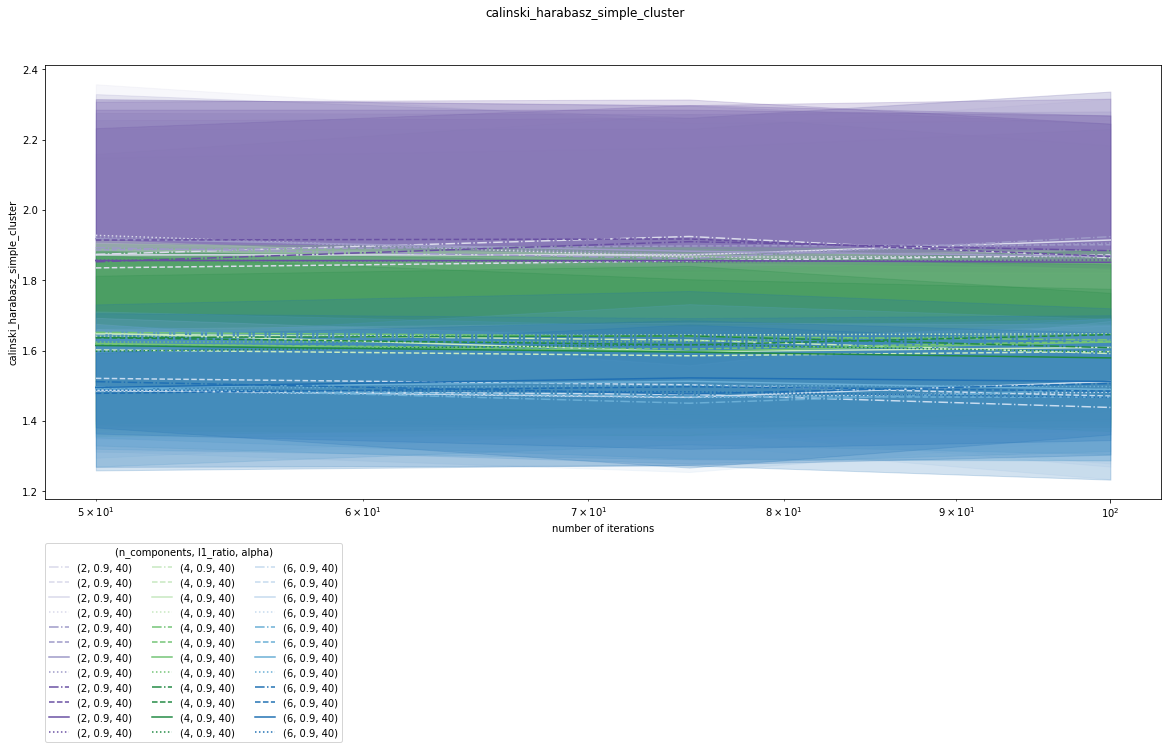

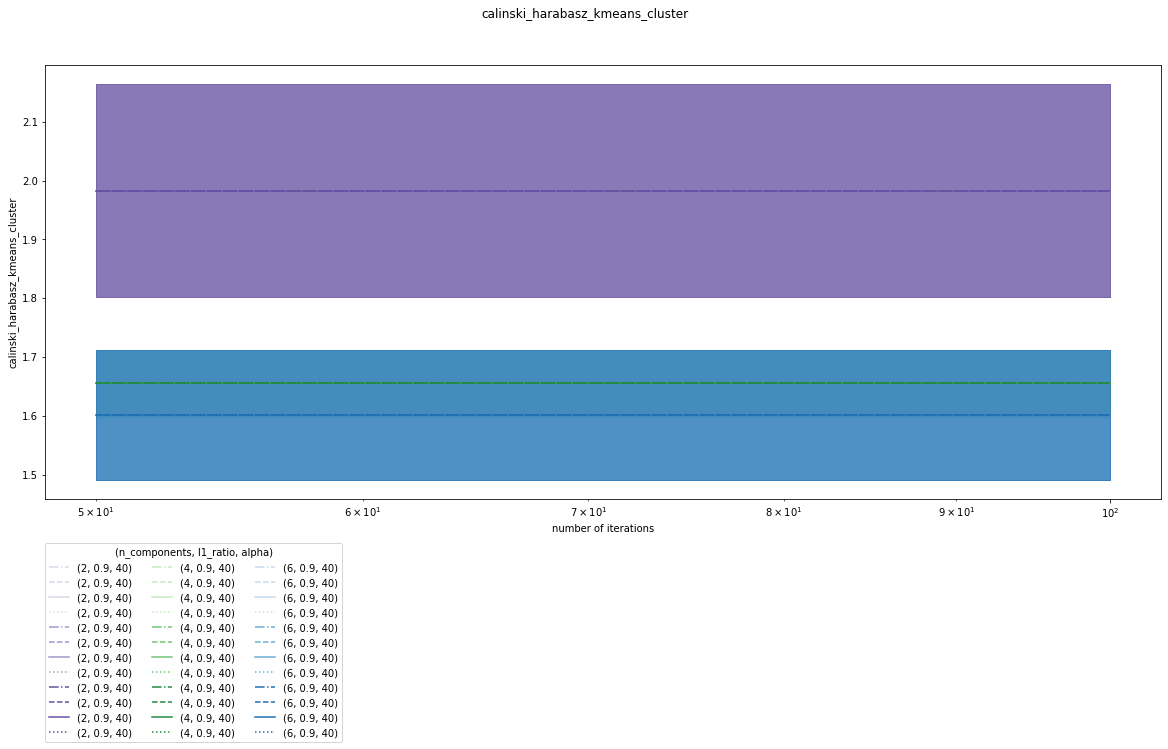

In [77]:
results = None

for score in scoring.keys():
    if results is None:
        results = pd.DataFrame(model_nmf.cv_results_['mean_test_'+score], columns = ['mean_test_'+score])\
                     .join(pd.DataFrame(model_nmf.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
    else:
        results = results.join(pd.DataFrame(model_nmf.cv_results_['mean_test_'+score], columns = ['mean_test_'+score]))\
                     .join(pd.DataFrame(model_nmf.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
for param in param_grid.keys():
    results = results.join(pd.DataFrame(model_nmf.cv_results_['param_'+param].data, columns = [param]))

for score in scoring.keys():
    fig, ax = plt.subplots(1,1, figsize = (20,8))
    fig.suptitle(score)
    
    color_group_map = {2: 'Purples', 4: 'Greens', 6: 'Blues'}
    l1_ratio_map = {0.25: 0.25, 0.5: 0.5, 0.75:0.75}
    alpha_map = {0.5:':', 0.1:'-.', 0.2:'--',0.4:'-'}

    for n_components, color_group in results.groupby('n_components'):
        cmap = matplotlib.cm.get_cmap(color_group_map[n_components])
        for l1_ratio, intensity_group in color_group.groupby('l1_ratio'):
            color = cmap(l1_ratio_map[l1_ratio])
            for alpha, linestyle_group in intensity_group.groupby('alpha'):
                linestyle = alpha_map[alpha]
                linestyle_group = linestyle_group.sort_values('max_iter')

                ax.plot(linestyle_group['max_iter'], linestyle_group['mean_test_'+score], 
                                          color = color, linestyle = linestyle, 
                                          label = '(%d, %.1f, %d)'%(n_components, learning_decay, learning_offset))
                ax.fill_between(x = linestyle_group['max_iter'].astype(float), 
                               y1 = linestyle_group['mean_test_'+score] - 1.96*linestyle_group['std_test_'+score],
                               y2 = linestyle_group['mean_test_'+score] + 1.96*linestyle_group['std_test_'+score],
                               color = color, alpha = 0.2)
    ax.legend(title = '(n_components, l1_ratio, alpha)', 
              ncol = 3, bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.)

    ax.set_xscale('log')
    ax.set_xlabel('number of iterations')
    ax.set_ylabel(score)